In [1]:
import tensorflow as tf
import codecs
import math
from tqdm import tqdm
from collections import defaultdict

In [2]:
from utils import display_text, clean_text, save_word2vec_tsv_format

In [3]:
# set params
VOCAB_SIZE = 10000
WINDOW_SIZE = 2
BATCH_SIZE = 64

In [4]:
a = !wc -l datasets/paracrawl/ParaCrawl.en-pl.pl
FILE_PATH = "datasets/paracrawl/ParaCrawl.en-pl.pl"
TOTAL_LINE = int(a[0].split(" ")[0])
TOTAL_LINE

1275162

In [5]:
# clean text, get vocab
NEW_FILE_PATH = "_".join([FILE_PATH.split(".")[0],  "cleaned.txt"])
vocab = clean_text(FILE_PATH, NEW_FILE_PATH, total_line=TOTAL_LINE).most_common(VOCAB_SIZE)

100%|██████████| 1275162/1275162 [00:25<00:00, 50106.16it/s]


In [6]:
# get mapper, rare word -> 0
word2idx = defaultdict(int)
word2idx.update([(v[0], k) for k,v in enumerate(vocab, 1)])
idx2word = {v:k for k,v in word2idx.items()}

In [7]:
def encode_file_with_mapper(file_path, word2idx):
    new_file_path = "_".join([file_path.split(".")[0],  "encoded.txt"])
    with codecs.open(file_path, "r", 'utf-8') as f, open(new_file_path, "w") as g:
        for sent in tqdm(f, total=TOTAL_LINE):
            line = " ".join(map(str, [word2idx[word] for word in sent.split()])) + "\n"
            g.write(line)
    return new_file_path
    

In [ ]:
ENCODED_FILE_PATH = encode_file_with_mapper(NEW_FILE_PATH, word2idx)

In [8]:
# build generator wrapper
def creator(self, file_path, window_size, total_line, batch_size, word2idx):
    self.file_path = file_path
    self.window_size = window_size
    self.total_line = total_line
    self.batch_size = batch_size
    self.word2idx = word2idx

def input_generator(self):
    counter = 0
    x_batch = []
    y_batch = []
    with codecs.open(self.file_path, "r", 'utf-8') as f:
        print("pierwszy")
#         for sent in tqdm(f, total=self.total_line):
        for sent in f:
            counter += 1
            words = sent.split()
            sent_len = len(words)
            if sent_len <= self.window_size:
                continue
            words = [self.word2idx[word] for word in words]
            for i in range(self.window_size, sent_len-self.window_size):
                if words[i] != 0:
                    for j in range(1, self.window_size + 1):
                        y_batch.append([words[i - j]])
                        x_batch.append(words[i])
                        y_batch.append([words[i + j]])
                        x_batch.append(words[i])

            if len(x_batch) < self.batch_size:
                continue
            x, y = x_batch[: self.batch_size], y_batch[: self.batch_size]
            x_batch, y_batch = x_batch[self.batch_size: ], y_batch[self.batch_size: ]
            yield x, y, counter
    print("drugi")
    if x_batch:
        return x_batch, y_batch
        
sentences = type("Input_Class", (object,), {"__init__": creator, "__iter__": input_generator})

# Train

In [9]:
# create graph
emb_params = {
    "batch_size": 64,
    "vocabulary_size": VOCAB_SIZE+1,
    "embedding_size": 32,
    "learning_rate": 0.1,
    "decay_steps": 1000,
    "decay_rate": 0.95,
    "num_sampled": 64
    
}

def create_model(kwargs):
    train_inputs = tf.placeholder(tf.int32, shape=[kwargs["batch_size"]])
    train_labels = tf.placeholder(tf.int32, shape=[kwargs["batch_size"], 1])
    embeddings = tf.Variable(
    tf.random_uniform([kwargs["vocabulary_size"], kwargs["embedding_size"]], -1.0, 1.0)
    )
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)
    nce_weights = tf.Variable(
        tf.truncated_normal([kwargs["vocabulary_size"], kwargs["embedding_size"]],
                          stddev=1.0 / math.sqrt(kwargs["embedding_size"])
                           )
    )
    nce_biases = tf.Variable(tf.zeros([kwargs["vocabulary_size"]]))
    loss = tf.reduce_mean(
        tf.nn.nce_loss(
            weights=nce_weights,
            biases=nce_biases,
            labels=train_labels,
            inputs=embed,
            num_sampled=kwargs["num_sampled"],
            num_classes=kwargs["vocabulary_size"]
        )
    )
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    global_step = tf.Variable(0, trainable = False) 
    learningRate = tf.train.exponential_decay(learning_rate = kwargs["learning_rate"], global_step = global_step,
                                              decay_steps = kwargs["decay_steps"], decay_rate = kwargs["decay_rate"], staircase = True)
    return tf.train.GradientDescentOptimizer(learning_rate=learningRate).minimize(loss), loss, train_inputs, train_labels, normalized_embeddings
    

In [11]:
# train emb
with tf.Session() as sess:
    generate_batch = sentences(file_path=NEW_FILE_PATH, window_size=WINDOW_SIZE, total_line=TOTAL_LINE, batch_size=BATCH_SIZE, word2idx=word2idx).__iter__()
    to_backprop, loss, train_inputs, train_labels, normalized_embeddings = create_model(emb_params)
    init = tf.global_variables_initializer()
    sess.run(init)
    for _ in range(TOTAL_LINE//BATCH_SIZE + 1):
        batch_inputs, batch_labels, counter = next(generate_batch)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
        sess.run(to_backprop, feed_dict=feed_dict)
#         print(counter)
        if _ % 5000 == 0:
            print('loss is: ', sess.run(loss, feed_dict=feed_dict))
    print("DONE")
    final_embeddings = normalized_embeddings.eval()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
pierwszy
loss is:  223.54382
loss is:  13.741388
loss is:  12.411037
loss is:  4.8492966
DONE


# Results

In [12]:
from sklearn.manifold.t_sne import TSNE
import matplotlib.pyplot as plt
def vis_emb(model, top_n=50, top_similar=10, figsize=(20, 20)):
    top_words=model.wv.index2word[100:100+top_n]
    top_words=np.append(np.array(top_words),np.array([np.array(model.most_similar_cosmul(w, topn=top_similar))
                                                      [:, 0] for w in top_words])).flatten()
    top_words=set(top_words)
    word_weights=[model.wv.word_vec(w, use_norm=False) for w in top_words]
    word_indexes=list(top_words)
    
    tsne = TSNE(n_components=2)
    wv_2 = tsne.fit_transform(word_weights)
    plt.figure(figsize=figsize)
    for i, word in enumerate(wv_2):
        plt.scatter(wv_2[i][0], wv_2[i][1]);
        plt.annotate(word_indexes[i], wv_2[i])

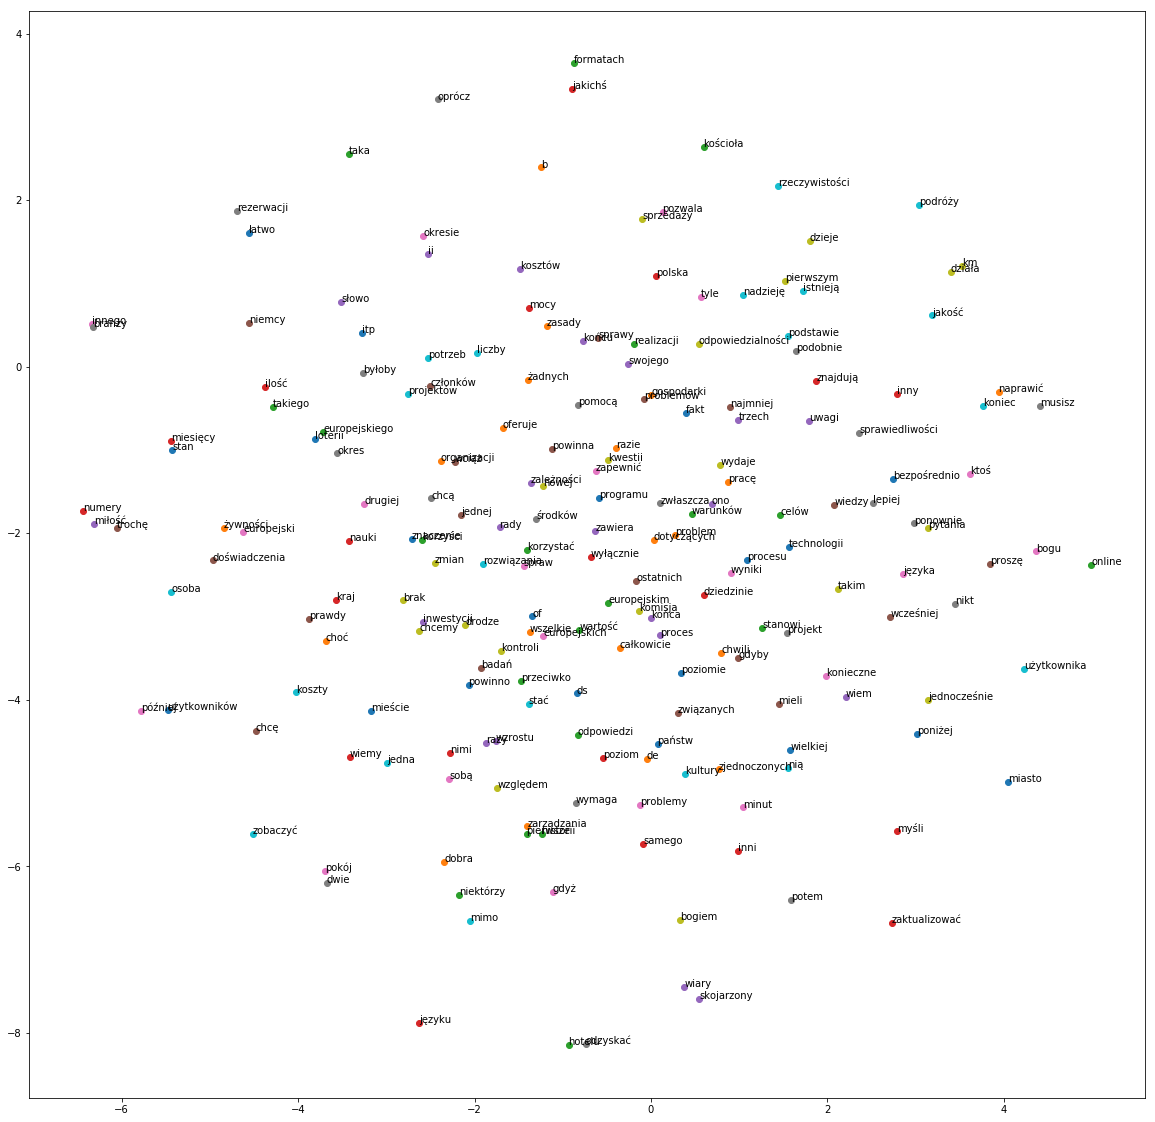

In [20]:
tsne = TSNE(n_components=2)
wv_2 = tsne.fit_transform(final_embeddings[500: 700])
plt.figure(figsize=(20,20))
for i, word in enumerate(wv_2):
    plt.scatter(wv_2[i][0], wv_2[i][1]);
    plt.annotate(idx2word[i+500], wv_2[i])